In [1]:
import os
import sys
import glob
import argparse
from keras import __version__
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Model
from keras.layers import Activation, Convolution2D, Dropout, Conv2D, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from cnn import mini_XCEPTION


import numpy as np
import requests
from io import BytesIO

from PIL import Image,ImageDraw,ImageFont
from keras.preprocessing import image
from keras.models import load_model, Sequential
import matplotlib.pyplot as plt

from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

from cnn import mini_XCEPTION
from utils.datasets import DataManager
from utils.datasets import split_data
from utils.preprocessor import preprocess_input
import matplotlib.pyplot as plt

Using TensorFlow backend.


https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
https://www.learnopencv.com/keras-tutorial-transfer-learning-using-pre-trained-models/

In [2]:
BAT_SIZE = 32
num_epochs = 10000
input_shape = (64, 64, 1)
validation_split = .2
verbose = 1
num_classes = 7
patience = 50
base_path = '/data/emotion_models/'
IM_WIDTH, IM_HEIGHT, _ = input_shape #fixed size for InceptionV3
NB_EPOCHS = 10000

FC_SIZE = 1024
NB_LAYERS_TO_REFINE = 3

In [3]:
# Note for this one the data dir is SFEW

dataset_name = 'SFEW'

log_file_path = base_path + dataset_name + '_emotion_training.log'
csv_logger = CSVLogger(log_file_path, append=False)
early_stop = EarlyStopping('val_loss', patience=patience)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1,
                              patience=int(patience/4), verbose=1)
trained_models_path = base_path + dataset_name + '_mini_XCEPTION'
model_names = trained_models_path + '.{epoch:02d}-{val_acc:.2f}.hdf5'
model_checkpoint = ModelCheckpoint(model_names, 'val_loss', verbose=1,
                                                save_best_only=True)
callbacks = [model_checkpoint, csv_logger, early_stop, reduce_lr]

train_data_dir = "/data/SFEW_Face/Train_Aligned_Faces"
val_data_dir = "/data/SFEW_Face/Val_Aligned_Faces"
weights_path = "/data/emotion_models/fer2013_mini_XCEPTION.94-0.62.hdf5"

In [4]:
# this time use the proper validation data
data_generator = ImageDataGenerator(
                        preprocessing_function=preprocess_input,
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)

    
train_generator = data_generator.flow_from_directory(
train_data_dir,
target_size=(IM_WIDTH, IM_HEIGHT),
batch_size=BAT_SIZE,
color_mode="grayscale")


validation_generator = data_generator.flow_from_directory(
val_data_dir, 
target_size=(IM_WIDTH, IM_HEIGHT),
batch_size=BAT_SIZE,
color_mode="grayscale")


Found 891 images belonging to 7 classes.
Found 431 images belonging to 7 classes.


(32, 64, 64, 1)
(64, 64, 1)


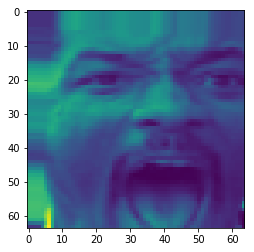

In [25]:
x,y = train_generator.next()
# for i in range(0,1):
#     image = x[i]
#     plt.imshow(image.transpose(2,1,0))
#     plt.show()
print(x.shape)
image = x[2]
print(image.shape)
plt.imshow(image.reshape(IM_WIDTH, IM_HEIGHT))
plt.show()

In [28]:
model = mini_XCEPTION(input_shape, num_classes)
model.load_weights(weights_path)

In [32]:
def setup_to_finetune(model):
    """Freeze the bottom NB_IV3_LAYERS and retrain the top 3 layers (only one with conv2d).
    model: _mini_XCEPTION
    """
    for layer in model.layers[:-1*NB_LAYERS_TO_REFINE]:
        layer.trainable = False
    for layer in model.layers[-1*NB_LAYERS_TO_REFINE:]:
        layer.trainable = True
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    

In [33]:
setup_to_finetune(model)

In [34]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 62, 62, 8)    72          input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_15 (BatchNo (None, 62, 62, 8)    32          conv2d_8[0][0]                   
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 62, 62, 8)    0           batch_normalization_15[0][0]     
__________________________________________________________________________________________________
conv2d_9 (

### Uncomment below to actually run it

In [ ]:
# import time
# start = time. time()


# refine_model.fit_generator( 
#     train_generator,
#     steps_per_epoch = train_generator.samples // BAT_SIZE,
#     validation_data = validation_generator, 
#     validation_steps = validation_generator.samples // BAT_SIZE,
#     epochs=NB_EPOCHS, verbose=1, callbacks=callbacks)


# end = time. time()
# print(end - start)

In [5]:
### Evaluate against the FER test data set
# this time use the proper validation data
test_data_dir = "/data/FER2013/PrivateTest"
data_generator = ImageDataGenerator(
                        preprocessing_function=preprocess_input,
                        featurewise_center=False,
                        featurewise_std_normalization=False)

    
test_generator = data_generator.flow_from_directory(
test_data_dir,
target_size=(IM_WIDTH, IM_HEIGHT),
batch_size=1,
color_mode="grayscale",
shuffle=False)




Found 7177 images belonging to 7 classes.


In [82]:
final_weights_path = "/data/emotion_models/SFEW_mini_XCEPTION.35-0.43.hdf5"
final_model = mini_XCEPTION(input_shape, num_classes)
final_model.load_weights(final_weights_path)

In [43]:
ground_truth = test_generator.classes
label2index = test_generator.class_indices
idx2label = dict((v,k) for k,v in label2index.items())

In [62]:


filenames = test_generator.filenames
nb_samples = len(filenames)

predictions = final_model.predict_generator(test_generator,steps = nb_samples)


In [64]:
y_classes = predictions.argmax(axis=-1)

In [65]:
len(y_classes)

7177

In [59]:

len(ground_truth)

7177

In [70]:
errors = np.where(y_classes != ground_truth)[0]



In [71]:
y_classes

array([3, 4, 2, ..., 4, 3, 5])

In [72]:
ground_truth

array([0, 0, 0, ..., 6, 6, 6], dtype=int32)

In [73]:
len(errors)

5969

(1, 64, 64, 1)
(64, 64, 1)


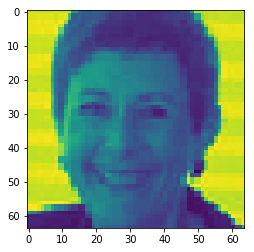

In [75]:
x,y = test_generator.next()
# for i in range(0,1):
#     image = x[i]
#     plt.imshow(image.transpose(2,1,0))
#     plt.show()
print(x.shape)
image = x[0]
print(image.shape)
plt.imshow(image.reshape(IM_WIDTH, IM_HEIGHT))
plt.show()

## it seems to have worked, but for some reason the accuracy is so low, going to test again using pre-refined model

## The accuracy is low because the generator automatically shuffle the data, we have to stop it otherwise it won't match the y flags

In [104]:
### Evaluate against the FER test data set
# this time use the proper validation data
test_data_dir = "/data/SFEW_Face/Test_Aligned_Faces"
data_generator = ImageDataGenerator(
                        preprocessing_function=preprocess_input,
                        featurewise_center=False,
                        featurewise_std_normalization=False)

    
test_generator = data_generator.flow_from_directory(
test_data_dir,
target_size=(IM_WIDTH, IM_HEIGHT),
batch_size=1,
color_mode="grayscale",
shuffle=False)


Found 0 images belonging to 0 classes.


In [80]:
model = mini_XCEPTION(input_shape, num_classes)
model.load_weights(weights_path)

In [84]:
filenames = test_generator.filenames
nb_samples = len(filenames)

predictions = model.predict_generator(test_generator,steps = nb_samples)


In [88]:
y_classes_old = predictions.argmax(axis=-1)
errors = np.where(y_classes_old != ground_truth)[0]

In [89]:
len(errors)

5922

In [90]:
print(5922.0/7177)

0.8251358506339697


In [105]:
### why accuracy so low! check again
test_data_dir = "/data/SFEW_Face/Val_Aligned_Faces"

 
test_generator = data_generator.flow_from_directory(
test_data_dir,
target_size=(IM_WIDTH, IM_HEIGHT),
batch_size=1,
color_mode="grayscale",
shuffle=False)

Found 431 images belonging to 7 classes.


In [114]:
final_model = mini_XCEPTION(input_shape, num_classes)
final_model.load_weights(final_weights_path)

In [107]:
ground_truth = test_generator.classes
label2index = test_generator.class_indices
idx2label = dict((v,k) for k,v in label2index.items())

filenames = test_generator.filenames
nb_samples = len(filenames)

predictions = final_model.predict_generator(test_generator,steps = nb_samples)


In [108]:
predictions

array([[0.0791631 , 0.02193147, 0.11939809, ..., 0.15370555, 0.10044391,
        0.1069942 ],
       [0.4036634 , 0.02254257, 0.297554  , ..., 0.07212307, 0.0312715 ,
        0.07254452],
       [0.06888822, 0.01881017, 0.30652082, ..., 0.083818  , 0.13310099,
        0.12440033],
       ...,
       [0.87169695, 0.00189363, 0.08334683, ..., 0.01781679, 0.00523324,
        0.01265741],
       [0.12204959, 0.01454979, 0.18506977, ..., 0.01064551, 0.1789466 ,
        0.47952715],
       [0.87169695, 0.00189363, 0.08334683, ..., 0.01781679, 0.00523324,
        0.01265741]], dtype=float32)

In [109]:
y_classes = predictions.argmax(axis=-1)
len(y_classes)
errors = np.where(y_classes != ground_truth)[0]

In [110]:
len(errors)

253

In [112]:
print(1-253.0/431)

0.41299303944315546


In [118]:

final_model_old = mini_XCEPTION(input_shape, num_classes)
final_model_old.load_weights(weights_path)

In [119]:

predictions_old = final_model_old.predict_generator(test_generator,steps = nb_samples)

In [120]:
y_classes_old = predictions_old.argmax(axis=-1)
len(y_classes_old)
errors_old = np.where(y_classes_old != ground_truth)[0]

In [121]:
len(errors)

253

### There are not enough new data to change the prediction much, instead try adding another layer to it

In [173]:
final_model_new =  mini_XCEPTION(input_shape, num_classes)
final_model_new.load_weights(weights_path)
final_model_new.layers.pop() # Get rid of the classification layer
final_model_new.layers.pop()


In [160]:
# final_model_new.summary()

In [130]:
# dont use this
# final_model_aaa=  mini_XCEPTION(input_shape, num_classes)
# final_model_aaa = Model( final_model_aaa.input, final_model_aaa.layers[-3].output) 
# final_model_aaa.summary()

In [161]:
# final_model_new =  mini_XCEPTION(input_shape, num_classes)
# final_model_new.layers.pop()
# final_model_new.layers.pop()


I actually ran into this recently, and I believe that this is an issue with how Model was rewritten to be more graph-based. In addition to the layers property models also have an outputs property, so when you pop layers off your last layer is left dangling in the model's output (which is why your model still thinks its output size is 1000).

A method to pop layers off and manage all the links correctly is needed, but until then I believe this would work: (my model compiles, but I haven't tried training it yet)


In [12]:

# ... Load pre-trained minixception model
final_model_new =  mini_XCEPTION(input_shape, num_classes)
final_model_new.load_weights(weights_path)
final_model_new.layers.pop() # Get rid of the Activation layer
final_model_new.layers[-1].outbound_nodes = []
final_model_new.outputs = [final_model_new.layers[-1].output]
output = final_model_new.get_layer('last_pool').output
output = Dense(56, activation='relu')(output)
output = Dense(7, activation='softmax')(output)
new_model = Model(final_model_new.input, output)


for layer in new_model.layers[:-2]:
    layer.trainable = False
for layer in new_model.layers[-2:]:
    layer.trainable = True

In [13]:
new_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 62, 62, 8)    72          input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_29 (BatchNo (None, 62, 62, 8)    32          conv2d_15[0][0]                  
__________________________________________________________________________________________________
activation_13 (Activation)      (None, 62, 62, 8)    0           batch_normalization_29[0][0]     
__________________________________________________________________________________________________
conv2d_16 

In [14]:
new_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
import time
start = time. time()


new_model.fit_generator( 
    train_generator,
    steps_per_epoch = train_generator.samples // BAT_SIZE,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // BAT_SIZE,
    epochs=NB_EPOCHS, verbose=1, callbacks=callbacks)


end = time. time()
print(end - start)

Epoch 1/10000
27/27 [==============================] - 2s 89ms/step - loss: 2.0765 - acc: 0.1947 - val_loss: 1.8935 - val_acc: 0.2306

Epoch 00001: val_loss did not improve from 1.61407
Epoch 2/10000
27/27 [==============================] - 2s 68ms/step - loss: 1.7406 - acc: 0.2872 - val_loss: 1.7913 - val_acc: 0.2882

Epoch 00002: val_loss did not improve from 1.61407
Epoch 3/10000
27/27 [==============================] - 2s 77ms/step - loss: 1.5960 - acc: 0.3744 - val_loss: 1.7077 - val_acc: 0.3108

Epoch 00003: val_loss did not improve from 1.61407
Epoch 4/10000
27/27 [==============================] - 2s 79ms/step - loss: 1.5894 - acc: 0.3977 - val_loss: 1.6817 - val_acc: 0.3365

Epoch 00004: val_loss did not improve from 1.61407
Epoch 5/10000
27/27 [==============================] - 2s 77ms/step - loss: 1.4909 - acc: 0.4588 - val_loss: 1.7057 - val_acc: 0.3308

Epoch 00005: val_loss did not improve from 1.61407
Epoch 6/10000
27/27 [==============================] - 2s 77ms/step - 

In [ ]:
Epoch 00179: val_loss did not improve from 1.61407
Epoch 180/10000
27/27 [==============================] - 2s 76ms/step - loss: 1.3928 - acc: 0.4879 - val_loss: 1.7044 - val_acc: 0.3985

Epoch 00180: val_loss did not improve from 1.61407
374.157114982605


Epoch 00071: val_loss did not improve from 1.61407
Epoch 72/10000
27/27 [==============================] - 2s 73ms/step - loss: 1.3947 - acc: 0.4860 - val_loss: 1.6663 - val_acc: 0.3885

Epoch 00072: val_loss did not improve from 1.61407
149.46879768371582